In [65]:
#import necessory libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [66]:
#Data load and sample data
df = pd.read_csv('singapore_airlines_reviews.csv')
print("dataset total columns and Rows:",df.shape)
print("dataFrame sample rows:")
df.head()

dataset total columns and Rows: (10000, 7)
dataFrame sample rows:


,published_date,published_platform,rating,type,text,title,helpful_votes
0,2024-03-12T14:41:14-04:00,Desktop,3,review,We used this airline to go from Singapore to L...,Ok,0
1,2024-03-11T19:39:13-04:00,Desktop,5,review,The service on Singapore Airlines Suites Class...,The service in Suites Class makes one feel lik...,0
2,2024-03-11T12:20:23-04:00,Desktop,1,review,"Booked, paid and received email confirmation f...",Don’t give them your money,0
3,2024-03-11T07:12:27-04:00,Desktop,5,review,"Best airline in the world, seats, food, servic...",Best Airline in the World,0
4,2024-03-10T05:34:18-04:00,Desktop,2,review,Premium Economy Seating on Singapore Airlines ...,Premium Economy Seating on Singapore Airlines ...,0


# **Data Cleaning**

In [67]:
# data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   published_date      10000 non-null  object
 1   published_platform  10000 non-null  object
 2   rating              10000 non-null  int64 
 3   type                10000 non-null  object
 4   text                10000 non-null  object
 5   title               9999 non-null   object
 6   helpful_votes       10000 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 547.0+ KB


In [68]:
#finding null values
df.isnull().sum()

,0
published_date,0
published_platform,0
rating,0
type,0
text,0
title,1
helpful_votes,0


In [69]:
#fill NAN value
df['title'].fillna('No info',inplace = True)

In [70]:
df['published_date'] = pd.to_datetime(df['published_date'])

# **Text Preprocessing**

In [71]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Tokenize
    tokens = word_tokenize(text.lower())
    # Remove stopwords
    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    return ' '.join(filtered_tokens)

df['processed_text'] = df['text'].apply(preprocess_text)


# **Exploratory Data Analysis**

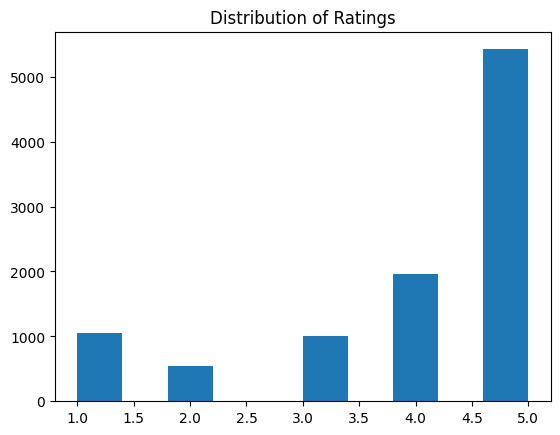

In [72]:
#Distribution Of Review
plt.hist(df['rating'])
plt.title('Distribution of Ratings')
plt.show()


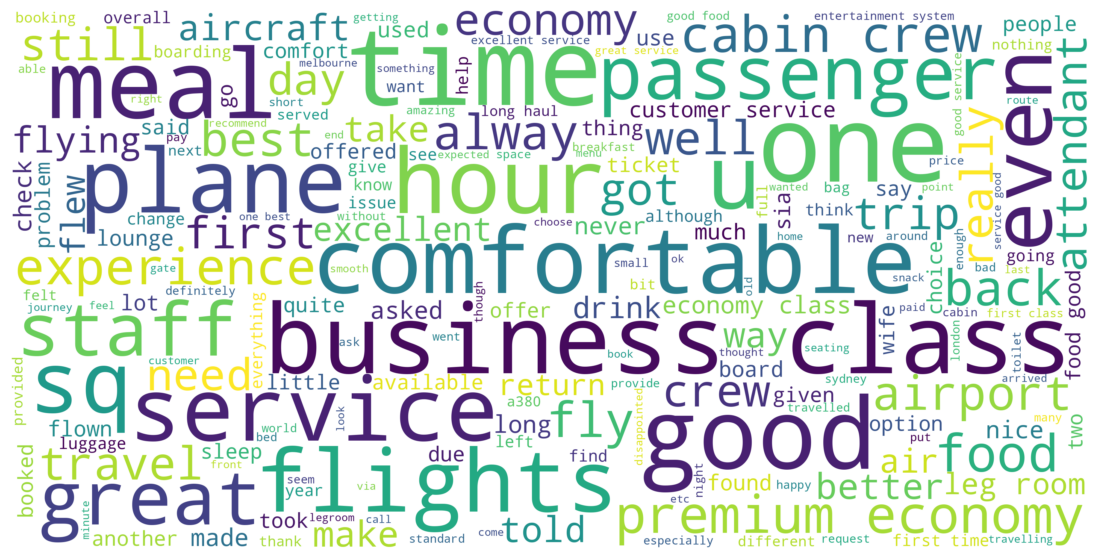

In [73]:
#Word Cloud For Review here we can find which Common words used
from wordcloud import WordCloud, STOPWORDS
additional_stopwords = set(STOPWORDS)
additional_stopwords.update(['flight', 'airline', 'singapore', 'airlines', 'seat', 'seats'])

# Combine the processed text into a single string
text = ' '.join(df['processed_text'])

# Generate the Word Cloud with improvements
wordcloud = WordCloud(width=1200, height=600,
                      background_color='white',
                      stopwords=additional_stopwords,
                      max_words=200,
                      max_font_size=120,
                      scale=3,
                      random_state=42
                     ).generate(text)

plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


# **Feature Engineering**

In [74]:
df['review_length'] = df['processed_text'].apply(lambda x: len(x.split()))
df['avg_word_length'] = df['processed_text'].apply(lambda x: np.mean([len(word) for word in x.split()]))


# **Sentiment Analysis**

Positive: 4-5 stars, Neutral: 3 stars, Negative: 1-2 stars.

In [75]:
def sentiment_label(rating):
    if rating > 3:
        return 'positive'
    elif rating == 3:
        return 'neutral'
    else:
        return 'negative'

df['sentiment'] = df['rating'].apply(sentiment_label)


###  **Text Vectorization:**

Use TF-IDF to convert text into numerical features.

In [76]:
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['processed_text']).toarray()
y = df['sentiment']

In [77]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)


# **Model Training:**

Split the data and train a Logistic Regression model.

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8423333333333334
              precision    recall  f1-score   support

    negative       0.77      0.69      0.73       481
     neutral       0.58      0.14      0.22       323
    positive       0.86      0.98      0.92      2196

    accuracy                           0.84      3000
   macro avg       0.74      0.60      0.62      3000
weighted avg       0.82      0.84      0.81      3000



# **Evaluate Model:**

Plot a confusion matrix to visualize the performance.

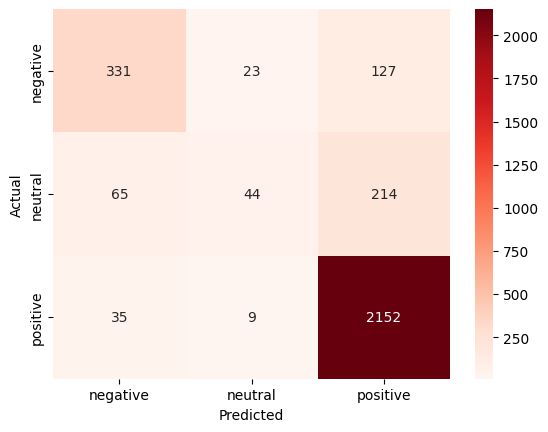

In [79]:
cm = confusion_matrix(y_test, y_pred, labels=['negative', 'neutral', 'positive'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


# **Rating Prediction**

Using the same TF-IDF features, but this time, the target variable is the rating.

In [80]:
df['review_length'] = df['processed_text'].apply(lambda x: len(x.split()))
df['avg_word_length'] = df['processed_text'].apply(lambda x: np.mean([len(word) for word in x.split()]))


In [81]:
y_rating = df['rating']


Model Training

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y_rating, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
print('MSE:', mean_squared_error(y_test, y_pred))
print('R2 Score:', r2_score(y_test, y_pred))


MSE: 3.456061632704372e+23
R2 Score: -1.9073192496698766e+23


Plot the predicted vs actual ratings.

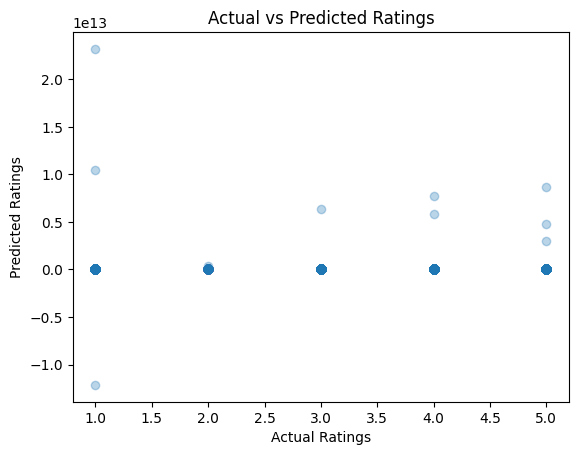

In [83]:
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Actual vs Predicted Ratings')
plt.show()


# **Conclusion:**
The analysis has successfully demonstrated the ability to predict customer ratings based on review text, providing a foundation for more nuanced understanding of customer feedback. By refining the model with the recommended improvements, Singapore Airlines can gain deeper insights into customer satisfaction and address areas of concern more effectively, ultimately leading to better service and customer experience